# BENCHMARK: 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [21]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

# Suppress warnings
warnings.filterwarnings('ignore')

# Helper functions

In [2]:
#Function to query unique_id and print df.

def query_unique_id(df, unique_id=None, target_col='y'):
    if unique_id:
        query_df = df[df['unique_id'] == unique_id]
    else:
        unique_id = random.sample(list(df['unique_id']), 1)[0]
        query_df = df[df['unique_id'] == unique_id]

    if not query_df.empty:
        sns.lineplot(data=query_df, x='ds', y=target_col)
        plt.xticks(rotation=45);
        plt.show()
    else:
        print(f"No data found for unique_id: {unique_id}")

    return query_df

# Data Load:

In [3]:
path = r'.\data\ts_kaggle_train.csv'
data = pd.read_csv(path, index_col=0, parse_dates=['date'])

### Transform to MLforecast nomenclature and save columns in useful lists:

In [4]:
# target = y
data.rename(columns={'date': 'ds', 'monthly_sales': 'y'}, inplace=True)

In [5]:
core_features = ['ds','unique_id']
STATIC_FEATURES = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# EDA

In [6]:
data["unique_id"].nunique() # we have 426 unique_ids = 426 time series

426

In [7]:
data.groupby('ds')['y'].sum().sort_values(ascending=False).head(10) #month with most sales

ds
2014-12-31    4874.0
2013-12-31    4514.0
2015-01-31    4223.0
2014-11-30    3681.0
2014-01-31    3508.0
2014-02-28    3462.0
2015-02-28    3436.0
2014-03-31    3383.0
2014-08-31    3309.0
2015-03-31    3245.0
Name: y, dtype: float64

In [8]:
data.groupby('city_id')['y'].sum().sort_values(ascending=False).head(10) #month with most sales

city_id
7     41360.0
22     7263.0
16     6593.0
21     5760.0
14     4437.0
18     3296.0
6      3051.0
13     2706.0
2      2659.0
11     2410.0
Name: y, dtype: float64

In [9]:
data.isnull().sum()

ds                          0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
y                         728
dtype: int64

### Target distribution:

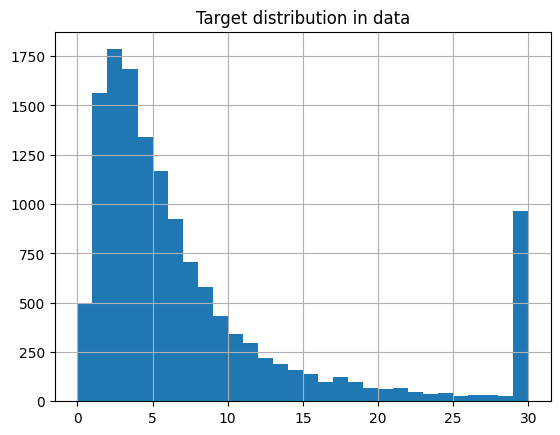

In [10]:
data['y'].hist(bins=30);
plt.title("Target distribution in data");

### Months distribution:

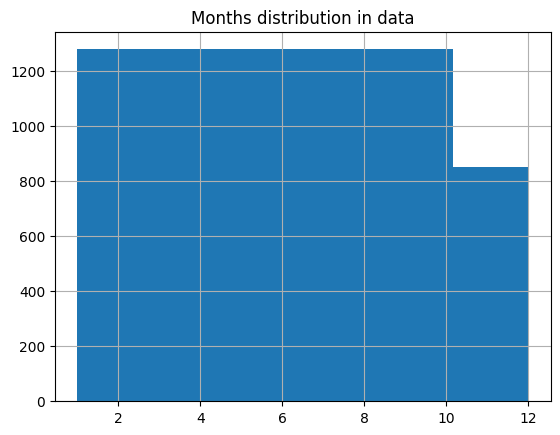

In [11]:
data['ds'].dt.month.hist(bins=12);
plt.title("Months distribution in data");

In [12]:
data.groupby('unique_id')['y'].apply(np.log1p).diff().reset_index()

,unique_id,level_1,y
0,12_11365,0,NaN
1,12_11365,7,-0.101783
2,12_11365,14,0.101783
3,12_11365,21,-0.101783
4,12_11365,28,0.101783
...,...,...,...
14479,7_7893,14435,-0.693147
14480,7_7893,14447,0.000000
14481,7_7893,14459,0.000000
14482,7_7893,14471,1.098612


In [13]:
log_diff_df = data.copy()
log_diff_df['y'] = log_diff_df.groupby('unique_id')['y'].transform(lambda series: np.log1p(series).diff())

### Target differences and log differences:

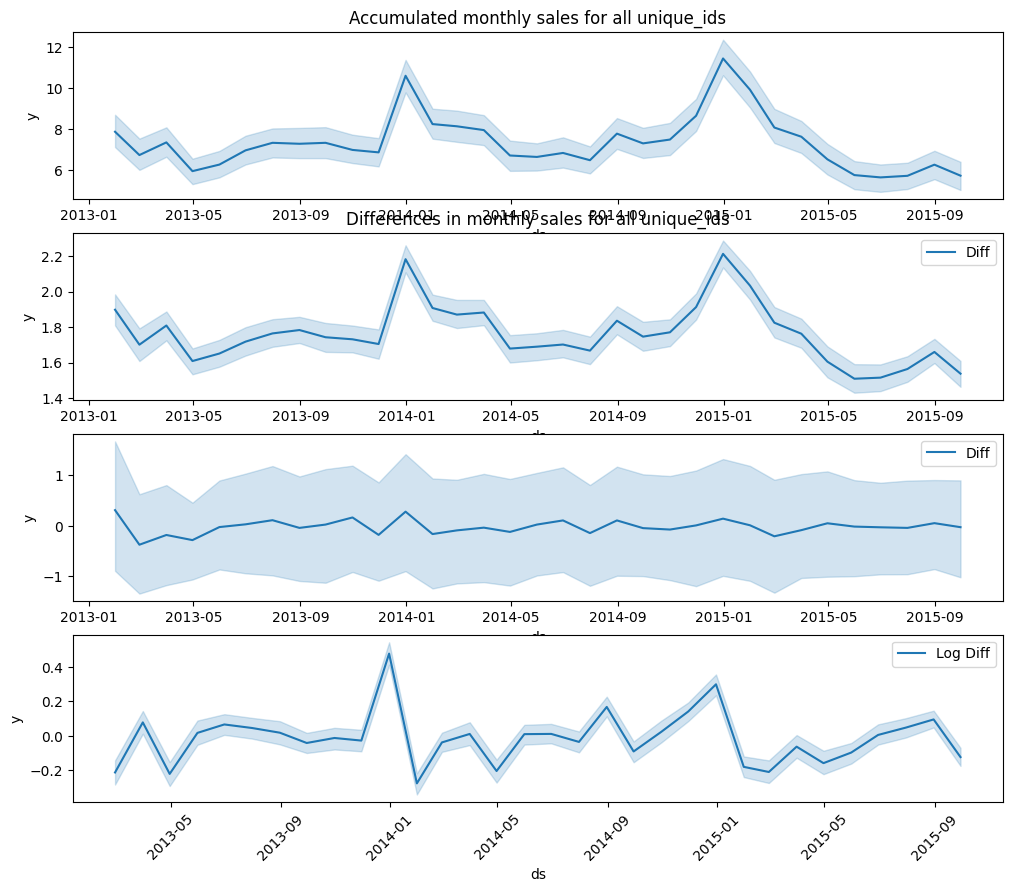

In [14]:
fig = plt.figure(figsize = (12, 10))
ax1, ax2, ax3, ax4 = fig.subplots(4, 1)

sns.lineplot(data = data, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for all unique_ids
plt.xticks(rotation=45);
ax1.set_title("Accumulated monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].apply(np.log1p), ax=ax2, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Accumulated LOG monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].diff(), ax=ax3, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Differences in monthly sales for all unique_ids");

sns.lineplot(data = log_diff_df, x = "ds", y = 'y', ax=ax4, label='Log Diff');
plt.xticks(rotation=45);
ax2.legend()

### Random samples sales patterns:

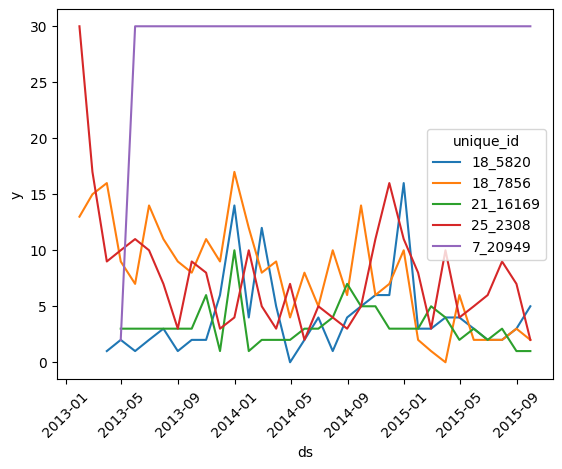

In [15]:
# sample 10 unique_ids to plot

sample_ids = random.sample(list(data["unique_id"].unique()), 5)
sns.lineplot(data = data[data['unique_id'].isin(sample_ids)], x = "ds", 
             y = "y", hue = "unique_id", legend = True);
plt.xticks(rotation=45);

### Clusters capturing target dispersion:

In [16]:
desc_stats = data.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])
kmeans = KMeans(n_clusters=3, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_
data2 = data.merge(desc_stats[['cluster']], on='unique_id')
data2.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

  File "c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,9.496714,7.472434,0.000000,4.000000,7.000000,13.000000,30.000000
1,4.027693,3.161066,0.000000,2.000000,3.000000,5.000000,23.000000
2,27.734542,6.072042,0.000000,30.000000,30.000000,30.000000,30.000000


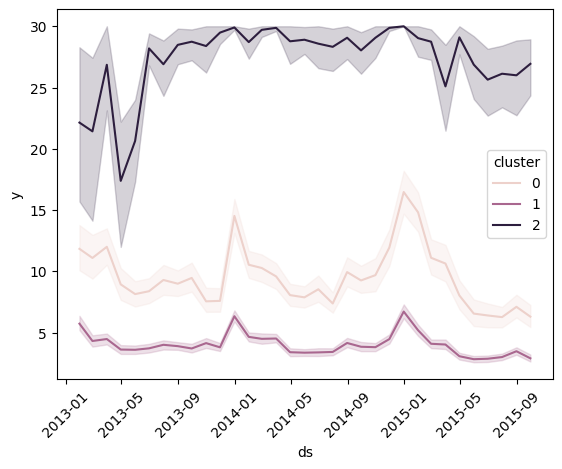

In [17]:
sns.lineplot(x='ds', y='y', hue='cluster', data=data2)
plt.xticks(rotation=45);

# NaN imputation:

- Imput target with 0 (NaN means no sales)
- Imput monthly_average_price with fill with previous value (bfill) and next value (ffill)

<Axes: xlabel='unique_id', ylabel='ds'>

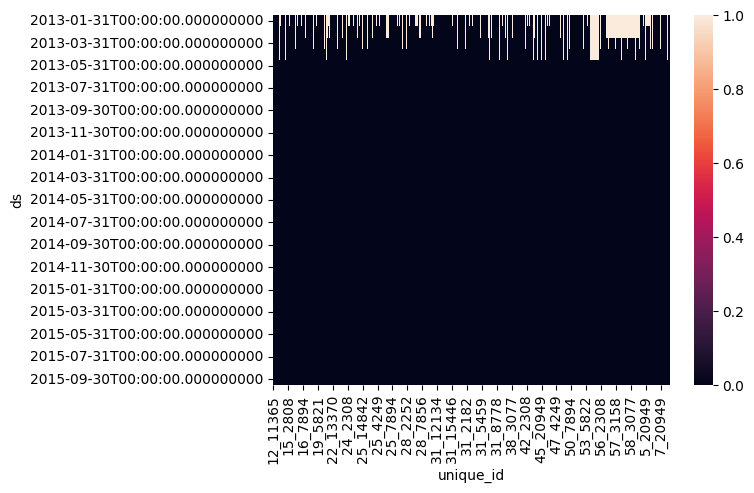

In [18]:
pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="y").isnull()

sns.heatmap(pivot_df)

<Axes: xlabel='unique_id', ylabel='ds'>

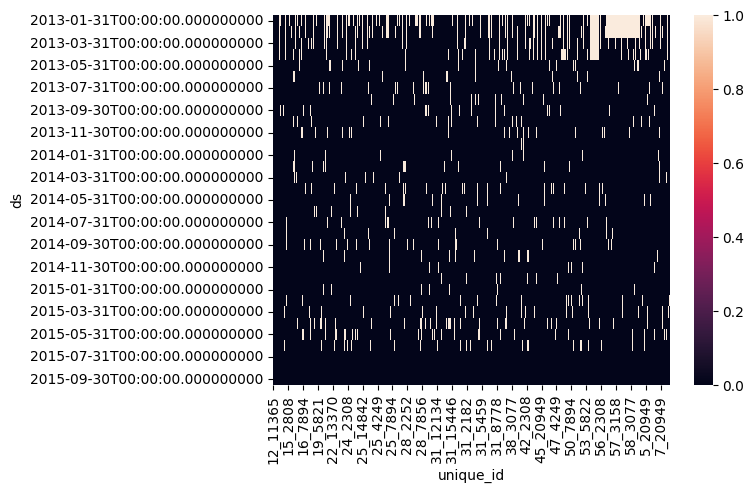

In [19]:
pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="monthly_average_price").isnull()

sns.heatmap(pivot_df)

### Simple imputation:

In [20]:
""" data.fillna({"y":0}, inplace = True)

data["monthly_average_price"] = data.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
) """

' data.fillna({"y":0}, inplace = True)\n\ndata["monthly_average_price"] = data.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(\n    lambda series: series.bfill().ffill()\n) '

### KNN imputation:

In [25]:
# Create a copy of the original data to avoid modifications
data_temp = data.copy()

# Extract time-based features from the 'ds' column because KNN needs numeric features
data_temp['month'] = data_temp['ds'].dt.month
data_temp['year'] = data_temp['ds'].dt.year
data_temp['quarter'] = data_temp['ds'].dt.quarter
data_temp['around_Xmas'] = data_temp['ds'].dt.month.isin([1,12])

# Transformar 'month' en sus representaciones seno y coseno
data_temp['month_sin'] = np.sin(2 * np.pi * data_temp['month'] / 12)
data_temp['month_cos'] = np.cos(2 * np.pi * data_temp['month'] / 12)

# Columns to impute using KNN
cols_with_missing = ['monthly_average_price', 'y']

# Drop unnecessary columns and create a copy for imputation
data_impute = data_temp.drop(columns=['ds', 'unique_id']).copy()

# Fit and transform the KNN imputer
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(data_impute)

# Create a DataFrame with the imputed values
imputed_df = pd.DataFrame(imputed_values, columns=data_impute.columns, index=data_impute.index)

# Merge the imputed columns with the original data, excluding the imputed ones
data_final = imputed_df[cols_with_missing].merge(
    data_temp.drop(columns=cols_with_missing), how='right', left_index=True, right_index=True
)

data = data_final.copy()

In [27]:
# replace imputed values in target to 0 for date 2015-10-31 (test data)
test_index = [sorted(list(data["ds"].unique()))[-1]]
data['y'] = np.where(data['ds'].isin(test_index), 0, data['y'])

# Simple engineering for analysis:

### Date features

In [82]:
""" #Adding some features
data['month'] = data['ds'].dt.month
data['year'] = data['ds'].dt.year
data['quarter'] = data['ds'].dt.quarter
data['around_Xmas'] = data['ds'].dt.month.isin([1,12]).astype(int)

# Transformar 'month' en sus representaciones seno y coseno
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12) """

### Revenue

In [28]:
data["revenue"] = (data["y"] * data["monthly_average_price"])

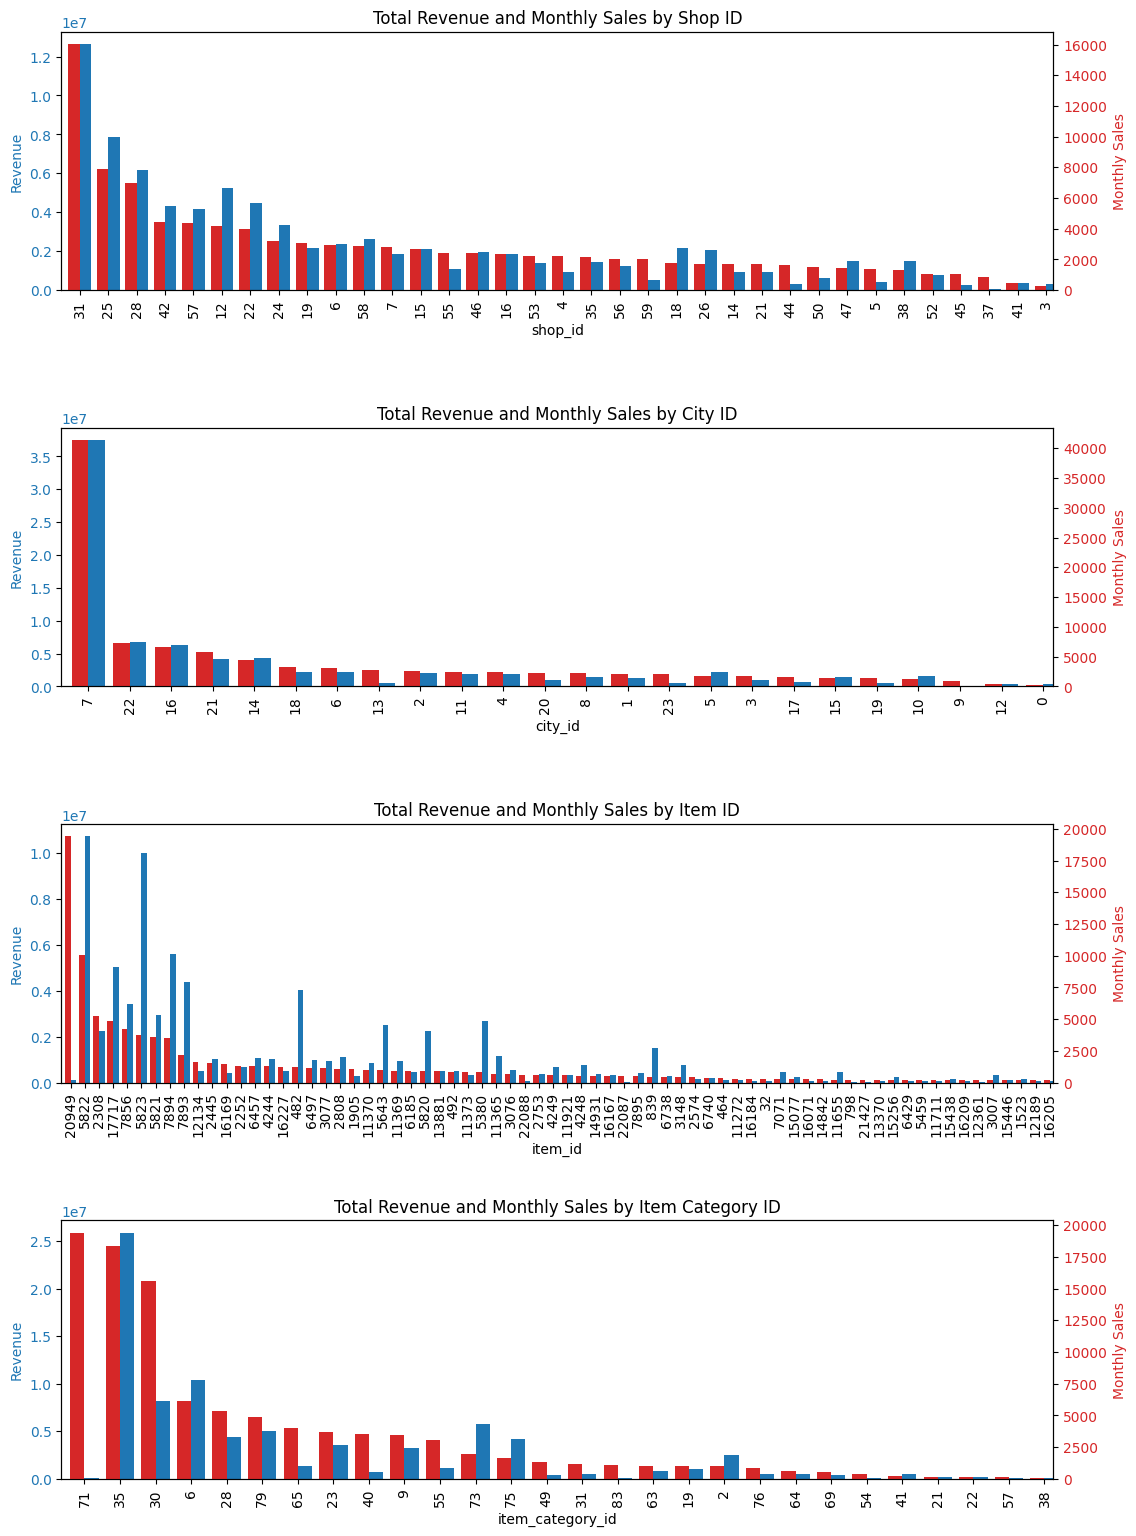

In [84]:
# Group data by different categories and calculate sums
grouped_shop = data.groupby("shop_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)
grouped_city = data.groupby("city_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)
grouped_item = data.groupby("item_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False).head(70)
grouped_category = data.groupby("item_category_id")[["revenue", "y"]].sum().sort_values(by="y", ascending=False)

# Create a figure with 4 subplots, one for each grouping
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

# Function to plot data on primary and secondary y-axes
def plot_grouped_data(ax, grouped_data, title):
    color = 'tab:blue'
    ax.set_xlabel('ID')
    ax.set_ylabel('Revenue', color=color)
    grouped_data['revenue'].plot(kind='bar', ax=ax, color=color, position=0, width=0.4)
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Monthly Sales', color=color)  
    grouped_data['y'].plot(kind='bar', ax=ax2, color=color, position=1, width=0.4)
    ax2.tick_params(axis='y', labelcolor=color)

    ax.set_title(title)
    ax.figure.tight_layout()  # Ensure the plot fits into the figure area

# Plot each grouped DataFrame on separate subplots
plot_grouped_data(axs[0], grouped_shop, 'Total Revenue and Monthly Sales by Shop ID')
plot_grouped_data(axs[1], grouped_city, 'Total Revenue and Monthly Sales by City ID')
plot_grouped_data(axs[2], grouped_item, 'Total Revenue and Monthly Sales by Item ID')
plot_grouped_data(axs[3], grouped_category, 'Total Revenue and Monthly Sales by Item Category ID')

plt.tight_layout(pad=3.0)
plt.show()

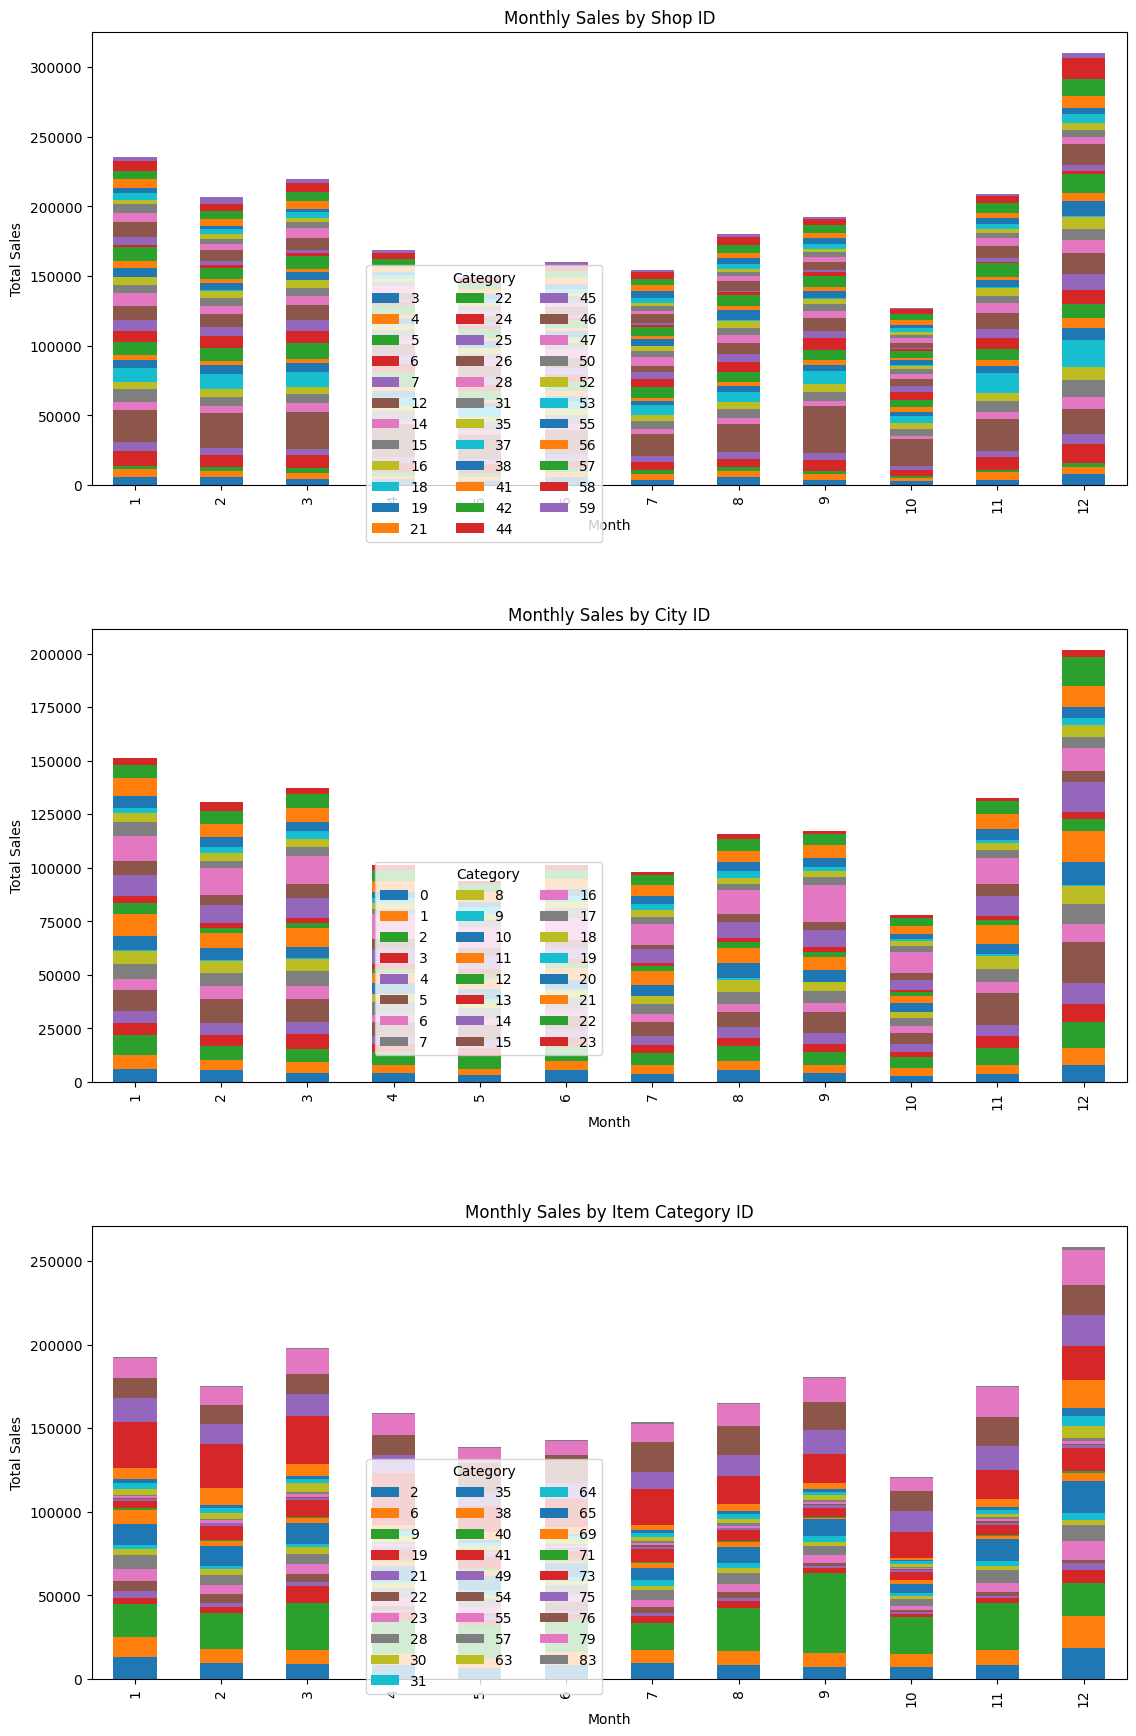

In [85]:
# Group data by different categories and calculate sums for each month
grouped_shop_month = data.groupby(["month", "shop_id"])["revenue"].mean().unstack(fill_value=0)
grouped_city_month = data.groupby(["month", "city_id"])["revenue"].mean().unstack(fill_value=0)
grouped_category_month = data.groupby(["month", "item_category_id"])["revenue"].mean().unstack(fill_value=0)

# Create a figure with 3 subplots, one for each grouping
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Function to plot data
def plot_grouped_data(ax, grouped_data, title):
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Sales')
    ax.set_title(title)
    ax.legend(title='Category', bbox_to_anchor=(0.5, 0.5), loc='upper right', ncol=3)

# Plot each grouped DataFrame on separate subplots
plot_grouped_data(axs[0], grouped_shop_month, 'Monthly Sales by Shop ID')
plot_grouped_data(axs[1], grouped_city_month, 'Monthly Sales by City ID')
plot_grouped_data(axs[2], grouped_category_month, 'Monthly Sales by Item Category ID')

plt.tight_layout(pad=3.0)
plt.show()


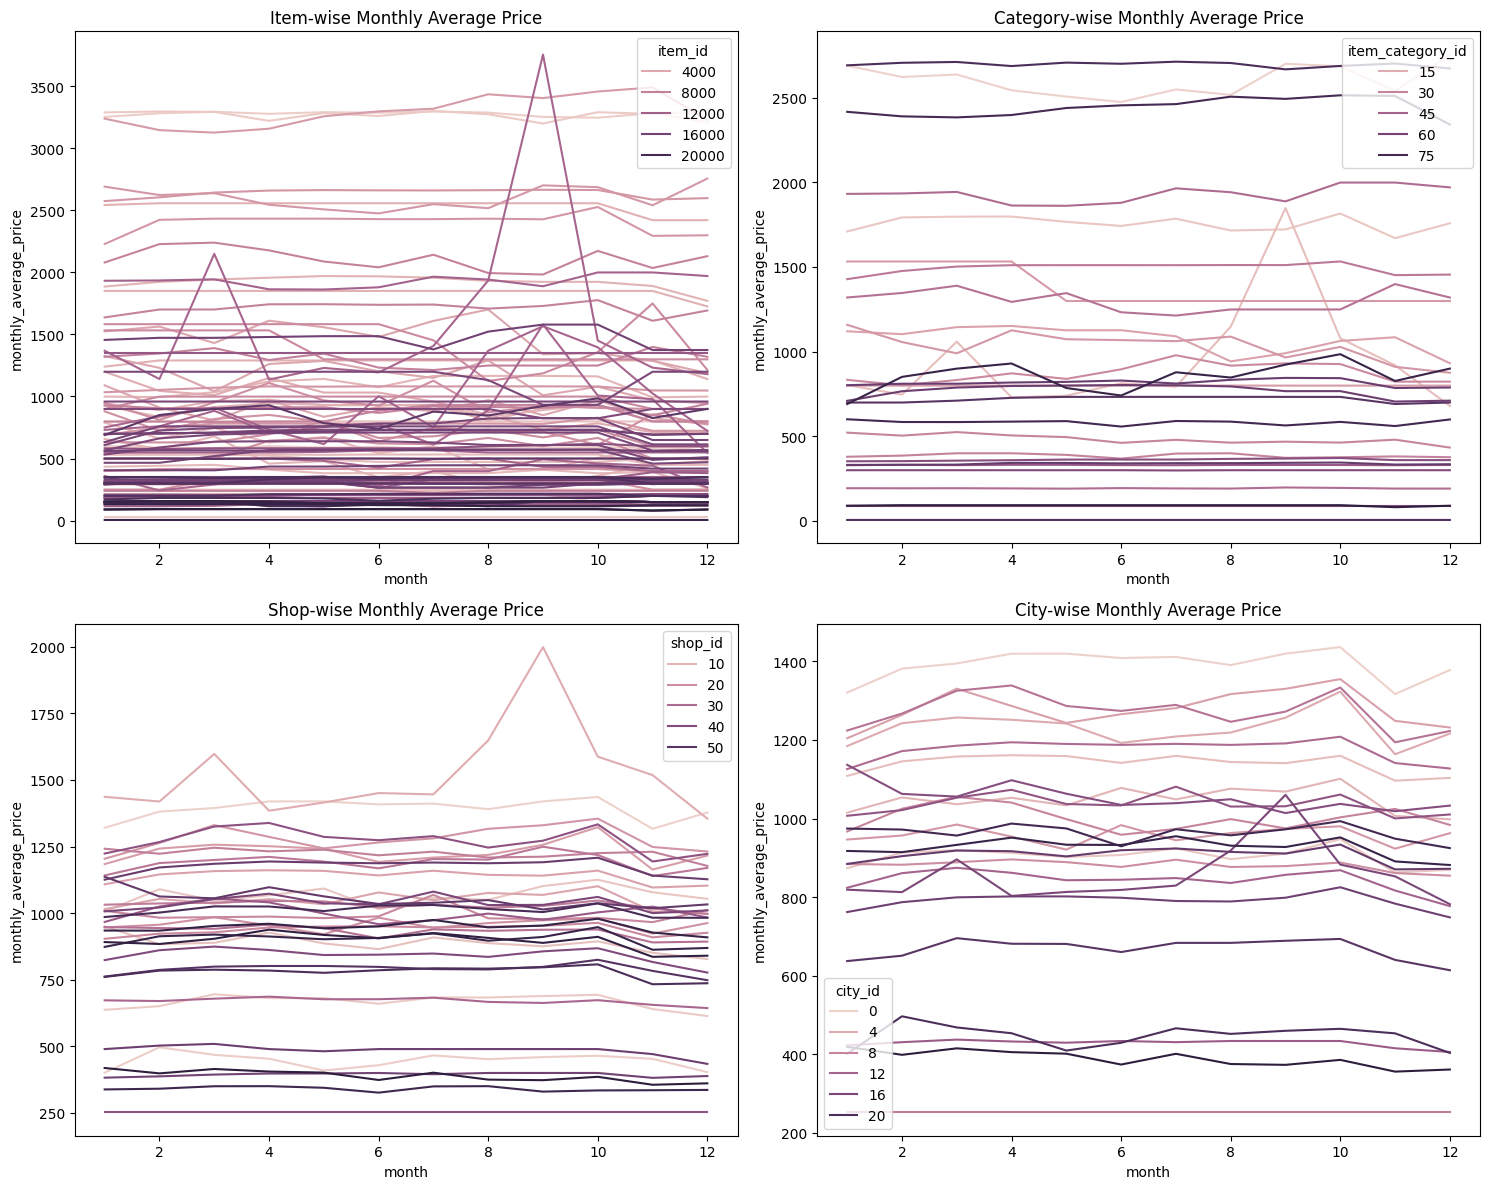

In [86]:
# Prepare the data
plot_data_item = data.groupby(['item_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','month'])['monthly_average_price'].mean().reset_index()
plot_data_city = data.groupby(['city_id','month'])['monthly_average_price'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise Monthly Average Price')

# Plot 2: Category-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise Monthly Average Price')

# Plot 3: Shop-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise Monthly Average Price')

# Plot 4: City-wise monthly average price
sns.lineplot(x='month', y='monthly_average_price', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise Monthly Average Price')

# Adjust the layout
plt.tight_layout()
plt.show()

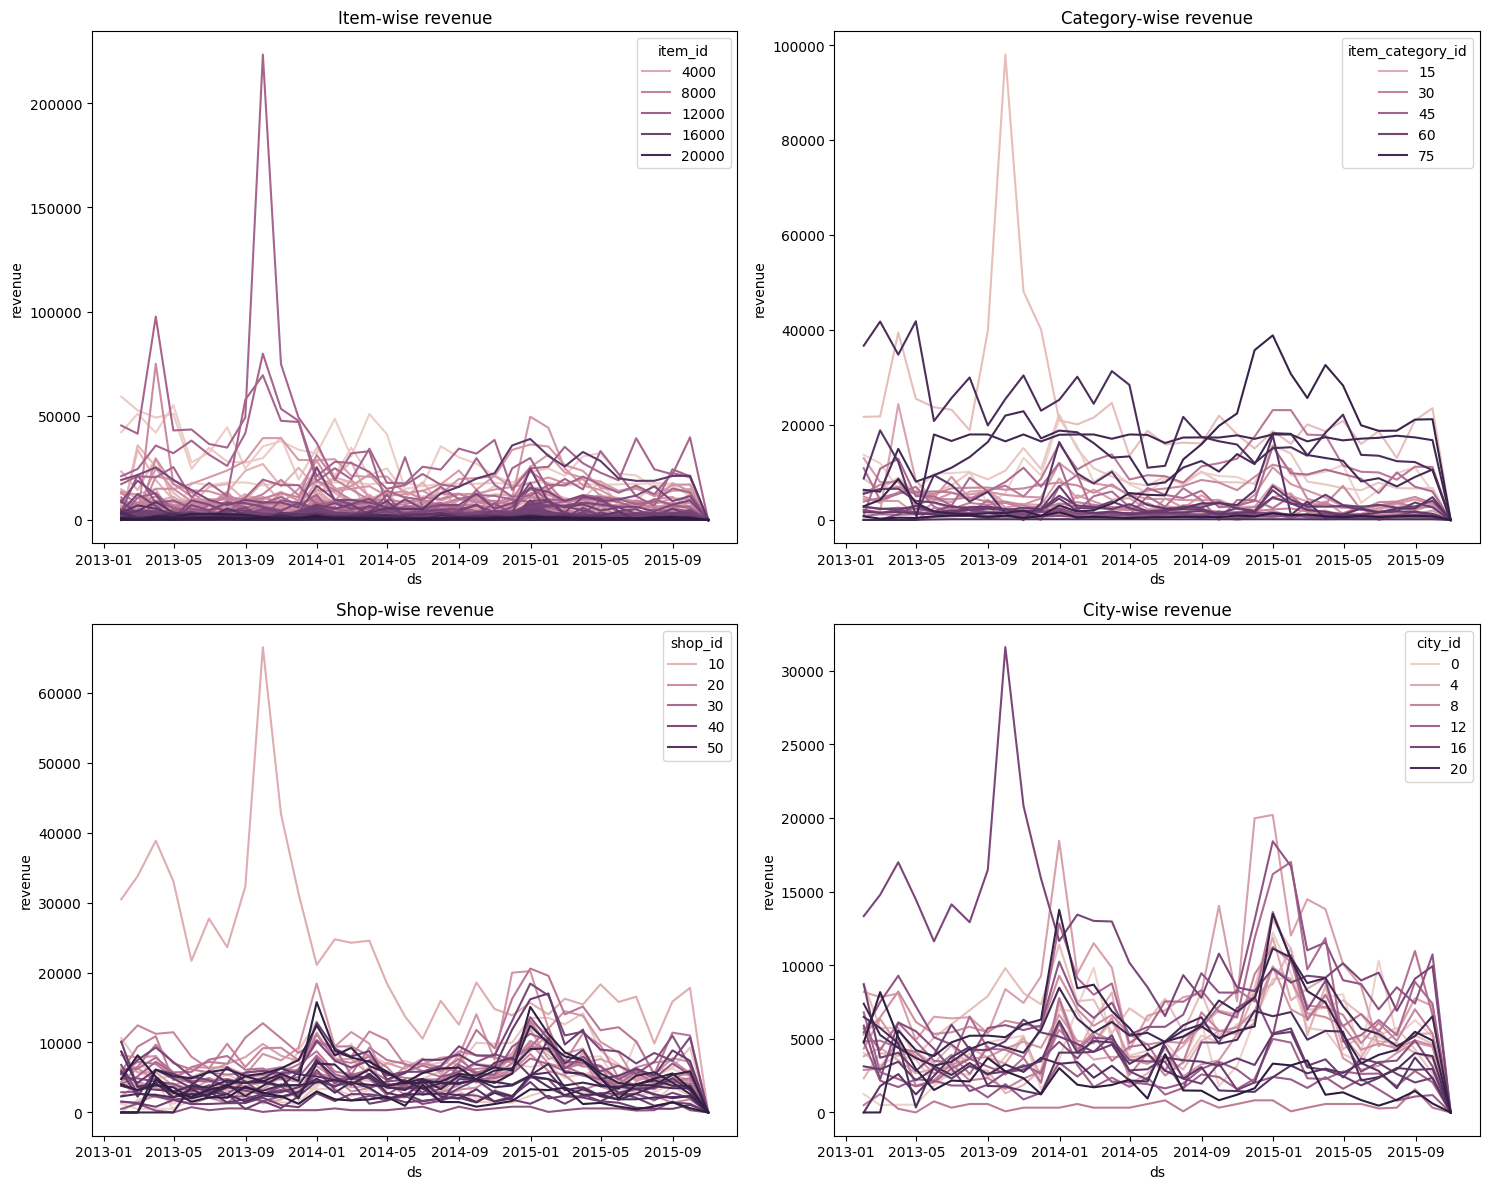

In [87]:
# Prepare the data
plot_data_item = data.groupby(['item_id','ds'])['revenue'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','ds'])['revenue'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','ds'])['revenue'].mean().reset_index()
plot_data_city = data.groupby(['city_id','ds'])['revenue'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise revenue
sns.lineplot(x='ds', y='revenue', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise revenue')

# Plot 2: Category-wise revenue
sns.lineplot(x='ds', y='revenue', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise revenue')

# Plot 3: Shop-wise revenue
sns.lineplot(x='ds', y='revenue', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise revenue')

# Plot 4: City-wise revenue
sns.lineplot(x='ds', y='revenue', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise revenue')

# Adjust the layout
plt.tight_layout()
plt.show()

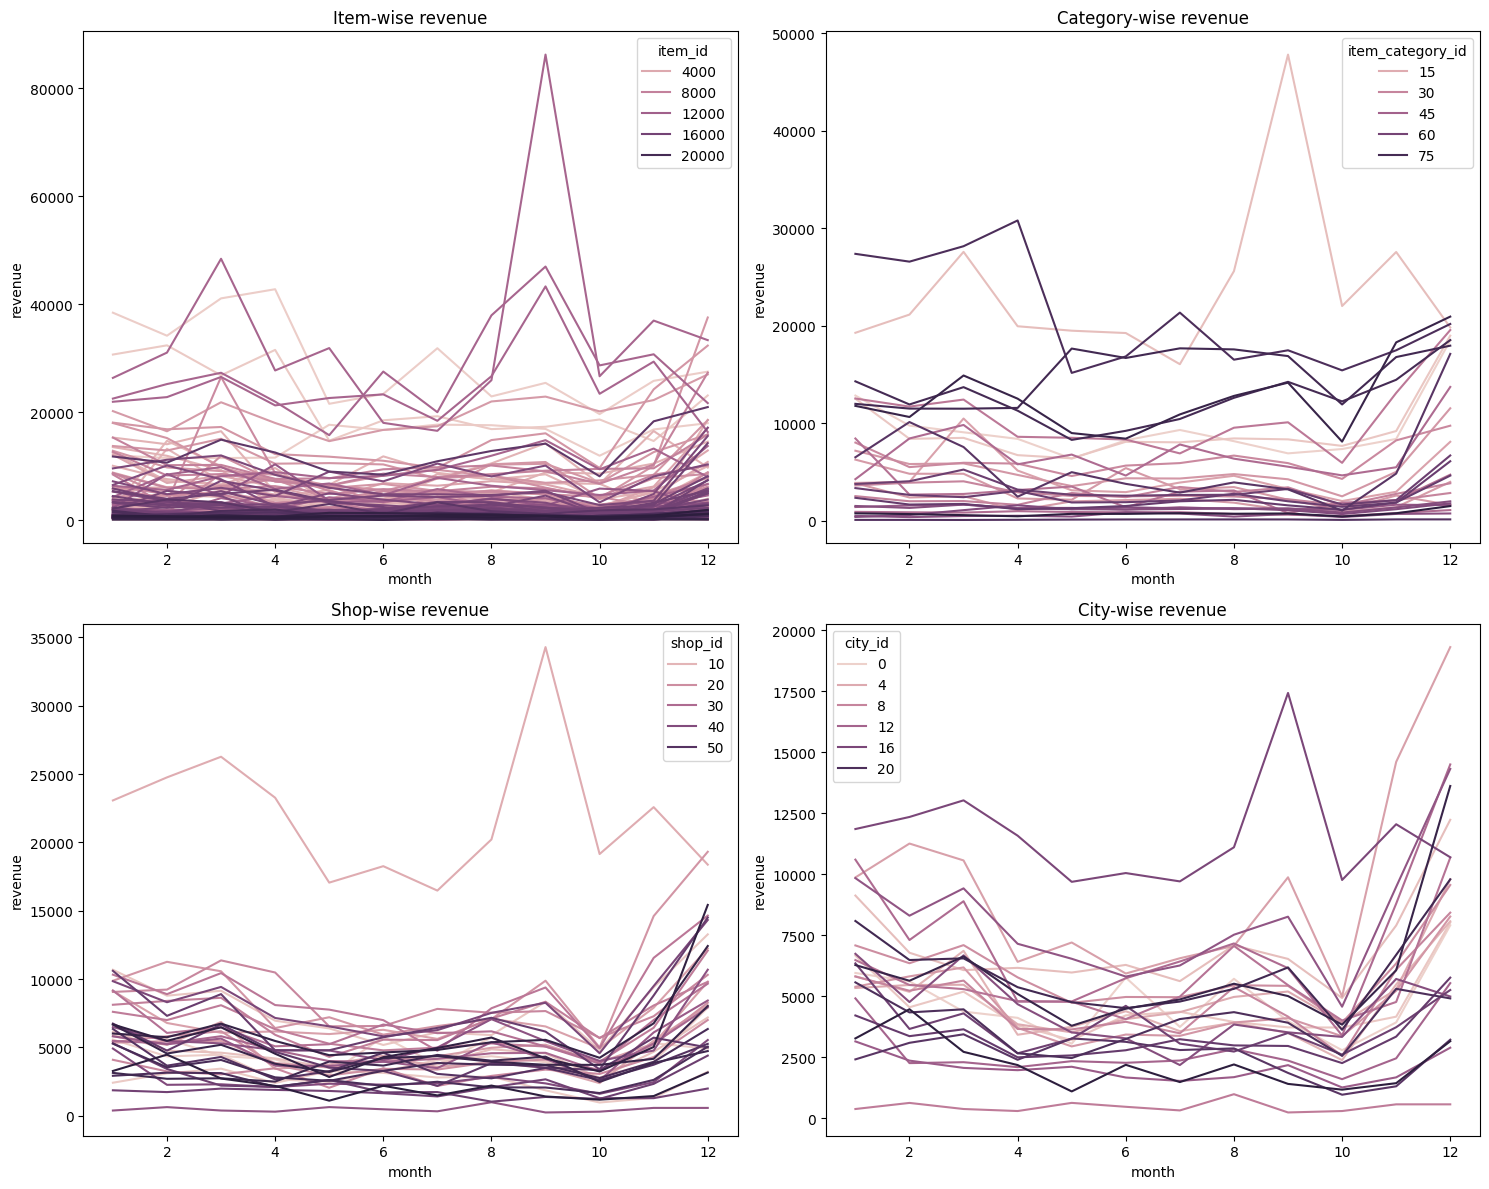

In [88]:
# Prepare the data
plot_data_item = data.groupby(['item_id','month'])['revenue'].mean().reset_index()
plot_data_category = data.groupby(['item_category_id','month'])['revenue'].mean().reset_index()
plot_data_shop = data.groupby(['shop_id','month'])['revenue'].mean().reset_index()
plot_data_city = data.groupby(['city_id','month'])['revenue'].mean().reset_index()

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Item-wise revenue
sns.lineplot(x='month', y='revenue', hue='item_id', data=plot_data_item, ax=axs[0, 0])
axs[0, 0].set_title('Item-wise revenue')

# Plot 2: Category-wise revenue
sns.lineplot(x='month', y='revenue', hue='item_category_id', data=plot_data_category, ax=axs[0, 1])
axs[0, 1].set_title('Category-wise revenue')

# Plot 3: Shop-wise revenue
sns.lineplot(x='month', y='revenue', hue='shop_id', data=plot_data_shop, ax=axs[1, 0])
axs[1, 0].set_title('Shop-wise revenue')

# Plot 4: City-wise revenue
sns.lineplot(x='month', y='revenue', hue='city_id', data=plot_data_city, ax=axs[1, 1])
axs[1, 1].set_title('City-wise revenue')

# Adjust the layout
plt.tight_layout()
plt.show()

# Save full features data:

In [29]:
data.head()

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,quarter,around_Xmas,month_sin,month_cos,revenue
0,1511.512626,30.0,2013-01-31,12_11365,16,12,9,11365,1,2013,1,True,0.5,0.866025,45345.378788
1,572.715278,30.0,2013-01-31,12_11369,16,12,9,11369,1,2013,1,True,0.5,0.866025,17181.458333
2,699.776786,30.0,2013-01-31,12_11370,16,12,9,11370,1,2013,1,True,0.5,0.866025,20993.303571
3,548.900000,6.0,2013-01-31,12_11373,16,12,9,11373,1,2013,1,True,0.5,0.866025,3293.400000
4,350.000000,3.0,2013-01-31,12_12231,16,12,49,12231,1,2013,1,True,0.5,0.866025,1050.000000


In [30]:
data.shape

(14484, 15)

In [31]:
data.to_pickle('./data/KNN_imputed_data_15f.pkl')